In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd

#matplotlib inline
#plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

Let load the data from the root file using the small libray that you can find in here [1]. 
This read a jason file that contains the features and the samples that will be used in the training. 

In [2]:
# Use wget to get the example file
! wget https://yhaddad.web.cern.ch/yhaddad/VBF/misc/hgg-double-fake-trees-training-2017.h5

--2018-02-02 10:45:07--  https://yhaddad.web.cern.ch/yhaddad/VBF/misc/hgg-double-fake-trees-training-2017.h5
Resolving yhaddad.web.cern.ch... 2001:1458:201:a4::100:18e, 188.184.65.148
Connecting to yhaddad.web.cern.ch|2001:1458:201:a4::100:18e|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221983169 (212M) [text/plain]
Saving to: 'hgg-double-fake-trees-training-2017.h5.2'

hgg-double-fake-tre 100%[===================>] 211.70M  30.3MB/s    in 7.2s    

2018-02-02 10:45:14 (29.4 MB/s) - 'hgg-double-fake-trees-training-2017.h5.2' saved [221983169/221983169]



In [3]:
indata = pd.read_hdf('hgg-double-fake-trees-training-2017.h5')

# Training

In [4]:
indata.head()

,Y,Z,avg_et,avg_pt,cr_region,diff_et,dijet_LeadJPt,dijet_Mjj,dijet_SubJPt,dijet_Zep,...,max_id,min_eta,min_id,n_jet_30,pass_id,sample,sublPho_PToM,subl_eta_cat,weight,weight_bins
37,0.0,0.0,43.238091,43.238091,PF,16.603214,151.844696,348.233521,82.960609,1.825968,...,0.863102,0.290157,-0.738678,2.0,False,QCD,0.275225,EE,0.010294,1.0
76,0.0,0.0,66.642220,66.642220,PF,21.410797,126.658180,366.362183,102.719681,3.985884,...,0.955794,1.347164,-0.981366,7.0,False,QCD,0.427067,EE,0.008930,2.0
120,0.0,0.0,54.669121,54.669121,PF,10.297127,129.755035,287.697021,110.578766,1.410670,...,0.917501,0.579953,-0.982321,3.0,False,QCD,0.384947,EB,0.007943,2.0
121,0.0,0.0,33.677986,33.677986,PF,13.121181,204.726944,302.357788,97.571335,0.526756,...,0.913246,0.407226,-0.496881,3.0,False,QCD,0.259094,EE,0.012077,0.0
194,0.0,0.0,87.695053,87.695053,PF,110.445801,260.928192,350.390686,118.736870,1.365499,...,0.973193,1.819954,-0.965216,3.0,False,QCD,0.276597,EE,0.010294,1.0


In [5]:
indata['dijet_centrality_gg'] = np.exp(-4*(indata.dijet_Zep/indata.dijet_abs_dEta)**2)

In [6]:
df_bkgs = indata[
    (indata['sample'] != 'data' ) & 
    (indata['sample'] != 'qcd'  ) & 
    (indata['sample'] != 'vbf'  ) &
    (indata['sample'] != 'gjet' ) & 
    (indata['sample'] != 'zee'  )
]
df_mc   = indata[
    (indata['sample'] != 'data') & 
    (indata['sample'] != 'vbf' ) &
    (indata['sample'] != 'zee' ) & 
    (indata['sample'] != 'QCD')
]
df_sign = indata[
    (indata['sample'] == 'vbf'  )
]
df_data = indata[
    (indata['sample'] == 'data')&
    (np.abs(indata['dipho_mass'] - 125)>10)
]

In [7]:
import numpy  as np
import pandas as pd
from sklearn.preprocessing import label_binarize
# == sklearn ==
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import cross_val_score

_features_ = [u'dijet_LeadJPt'  ,u'dijet_SubJPt', 
              u'dijet_abs_dEta' ,u'dijet_Mjj', 
              u'dijet_centrality_gg',u'dijet_dipho_dphi_trunc',
              u'dijet_dphi'     ,u'dijet_minDRJetPho',
              u'leadPho_PToM'   ,u'sublPho_PToM']

def vbf_presel(data):
    return (
        (data["leadPho_PToM"       ]> (1/3.0))&
        (data["sublPho_PToM"       ]> (1/4.0))&
        (data["dijet_LeadJPt"      ]> 40     )& 
        (data["dijet_SubJPt"       ]> 30     )&
        (data["dijet_Mjj"          ]> 250    )&
        (data["dipho_mass"         ]> 100    )&
        (data["dipho_mass"         ]< 180    ))

def vbf_relax(data):
    return (
        (data["leadPho_PToM"       ]> (1/4.0))&
        (data["sublPho_PToM"       ]> (1/5.0))&
        (data["dijet_LeadJPt"      ]> 30     )& 
        (data["dijet_SubJPt"       ]> 20     )&
        (data["dijet_Mjj"          ]> 100    )&
        (data["dipho_mass"         ]> 100    )&
        (data["dipho_mass"         ]< 180    ))

In [8]:
df_sign.columns

Index([u'Y', u'Z', u'avg_et', u'avg_pt', u'cr_region', u'diff_et',
       u'dijet_LeadJPt', u'dijet_Mjj', u'dijet_SubJPt', u'dijet_Zep',
       u'dijet_abs_dEta', u'dijet_dipho_dphi', u'dijet_dipho_dphi_trunc',
       u'dijet_dphi', u'dijet_jet1_QGL', u'dijet_jet2_QGL', u'dijet_leadEta',
       u'dijet_minDRJetPho', u'dijet_mva', u'dijet_subleadEta', u'dipho_PToM',
       u'dipho_cosphi', u'dipho_dijet_MVA', u'dipho_leadEt', u'dipho_leadEta',
       u'dipho_leadIDMVA', u'dipho_leadPt', u'dipho_lead_elveto',
       u'dipho_lead_sieie', u'dipho_lead_sigmaEoE', u'dipho_mass',
       u'dipho_mva', u'dipho_subleadEt', u'dipho_subleadEta',
       u'dipho_subleadIDMVA', u'dipho_subleadPt', u'dipho_sublead_elveto',
       u'dipho_sublead_sieie', u'dipho_sublead_sigmaEoE', u'eta_cat',
       u'fail_id', u'isvbf', u'leadPho_PToM', u'lead_eta_cat', u'm_sideband',
       u'max_eta', u'max_id', u'min_eta', u'min_id', u'n_jet_30', u'pass_id',
       u'sample', u'sublPho_PToM', u'subl_eta_cat', u'wei

In [9]:
df_bkgs = df_bkgs[vbf_presel(df_bkgs)]
df_mc   = df_mc  [vbf_presel(df_mc  )]
df_sign = df_sign[vbf_presel(df_sign)]
df_data = df_data[vbf_presel(df_data)]

D  =  np.concatenate((df_sign[_features_],df_bkgs[_features_]))
Y  =  np.concatenate((np.ones(df_sign.shape[0]),np.zeros(df_bkgs.shape[0])))
W  =  np.concatenate((df_sign['weight'],df_bkgs['weight']))
I  =  np.concatenate((df_sign['sample'],df_bkgs['sample']))
O  =  np.concatenate((df_sign['dipho_mass'],df_bkgs['dipho_mass']))

X_data  =  np.concatenate((df_sign[_features_],df_data[_features_]))
Y_data  =  np.concatenate((np.ones(df_sign.shape[0]),np.zeros(df_data.shape[0])))
W_data  =  np.concatenate((df_sign['weight'],df_data['weight']))
I_data  =  np.concatenate((df_sign['sample'],df_data['sample']))
O_data  =  np.concatenate((df_sign['dipho_mass'],df_data['dipho_mass']))

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

np.random.seed(42)

(
    X_train, X_valid, 
    Y_train, Y_valid,
    W_train, W_valid,
    I_train, I_valid,
    O_train, O_valid
    
) = train_test_split(
    D, Y, W, I, O,
    test_size=0.8,  # 0.2 was thedefault
    random_state=17
)

W_train = W_train * (W.sum()/W_train.sum())
W_valid = W_valid * (W.sum()/W_valid.sum())

In [11]:
import collections 
print "number of classes (samples) inside the dataset ... train (validation)"
for p in collections.Counter(I):
    print "%10s nevent = %10.2f [%10.2f]" % ( p, W_train[I_train==p].shape[0], W_valid[I_valid==p].shape[0])

number of classes (samples) inside the dataset ... train (validation)
       ggh nevent =    2766.00 [  10881.00]
       vbf nevent =   28956.00 [ 115709.00]
     dipho nevent =  117222.00 [ 468203.00]
       QCD nevent =   23473.00 [  94876.00]


In [12]:
def normalize_weights(weights, classes):
    weights_ = np.copy(weights)
    for cl in np.unique(classes):
        weights_[classes==cl] = weights_[classes==cl]/np.sum(weights_[classes==cl])
    return weights_

weights_train = {}

weights_train['target'] = normalize_weights(W_train,Y_train)

In [31]:
from sklearn.ensemble   import GradientBoostingClassifier as GBC
from pprint import pprint

classifier = {
    "moriond" : GBC(
        learning_rate=0.1,
        max_depth=5,
        max_features='auto', 
        min_samples_leaf=0.001, 
        min_samples_split=2,
        n_estimators=100,
        presort='auto', 
        subsample=0.5, 
        verbose=1,
        warm_start=False)
}
pprint(classifier)

{'moriond': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.001, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=1,
              warm_start=False)}


In [32]:
from sklearn.base import clone

clfs = {}
for i in weights_train:
    for c in classifier:
        if 'xsec' in i and 'new' in c: continue
        print i +'-'+ c
        clfs[i+'-'+c]   = clone(classifier[c])

target-moriond


In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
rocs = {}
prob = {}
cfun = {}

rocs_valid = {}
prob_valid = {}
cfun_valid = {}

for i, c in clfs.items():
    print ' -- training : ', i
    c.fit ( X_train, Y_train, sample_weight= weights_train[i.split('-')[0]])
    
    prob[i] = c.predict_proba(X_train)[:,1]
    rocs[i] = roc_curve( Y_train,prob[i],sample_weight=W_train)

    prob_valid[i] = c.predict_proba(X_valid)[:,1]
    rocs_valid[i] = roc_curve( Y_valid,prob_valid[i],sample_weight=W_valid)

 -- training :  target-moriond
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3014           0.0825            1.09m
         2           1.2310           0.0666            1.07m
         3           1.1737           0.0569            1.04m
         4           1.1209           0.0480            1.02m
         5           1.0808           0.0411            1.01m
         6           1.0485           0.0351           59.80s
         7           1.0129           0.0304           58.95s
         8           0.9899           0.0260           57.79s
         9           0.9590           0.0227           56.96s
        10           0.9360           0.0204           56.17s
        20           0.8173           0.0063           48.43s
        30           0.7759           0.0021           44.43s
        40           0.7378           0.0008           44.48s
        50           0.7404           0.0003           38.53s
        60           0.7275          -

In [34]:
def evaluate_sklearn(cls, vals, coef=1):
    scale = 1.0 / cls.n_estimators
    ret = np.zeros(vals.shape[0])

    learning_rate = cls.learning_rate
    for itree, t in enumerate(cls.estimators_[:, 0]):
        r = t.predict(vals)
        ret += r * scale
    return 2.0/(1.0 + np.exp(-coef/learning_rate * ret)) - 1

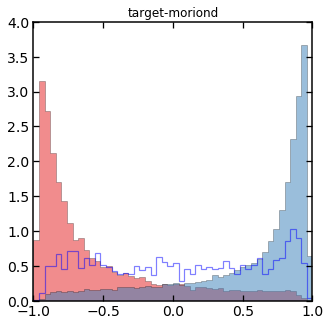

In [35]:
for i in clfs.keys():
    tmva_train = evaluate_sklearn(clfs[i],X_train)
    tmva_valid = evaluate_sklearn(clfs[i],X_valid)
    plt.figure(figsize=(5,5))
    plt.title(i)
    plt.hist(tmva_train[(Y_train<0.5)], bins=50,
             weights=W_train[(Y_train<0.5)], 
             range=[-1,1],
             alpha=0.5, histtype='stepfilled', normed=1)
    plt.hist(tmva_train[(Y_train>0.5)], bins=50,
             weights=W_train[(Y_train>0.5)], 
             range=[-1,1],
             alpha=0.5, histtype='stepfilled', normed=1)

    plt.hist(tmva_train[I_train == 'ggh'], bins=50,
             weights=W_train[I_train == 'ggh'], 
             range=[-1,1],
             alpha=0.5, histtype='step', color = 'blue',lw=1.2, normed=1)
    plt.show()

In [36]:
from sklearn.metrics           import roc_curve, auc, roc_auc_score
def plot_rocs(rocs = {}, dump=False, range=[[0,1],[0,1]], label='', title='', rocs_train=None):
    plt.figure(figsize=(5,4.5))
    for k, spine in plt.gca().spines.items():
        spine.set_zorder(10)
    plt.gca().xaxis.grid(which='major', color='0.7' , linestyle='--',dashes=(5,1),zorder=0)
    plt.gca().yaxis.grid(which='major', color='0.7' , linestyle='--',dashes=(5,1),zorder=0)
    print '--- draw some roc curve with scores : '
    for name,roc in rocs.items():
        fpr, tpr, thr = roc
        roc_auc_ = auc(fpr, tpr, reorder=True)
        print "%20s %1.4f" % ( name, roc_auc_ )
        plt.plot(fpr, tpr, label=name+'(area = %0.4f)'%(roc_auc_), zorder=5, lw=1.2)
    if rocs_train is not None : 
        for name,roc in rocs_train.items():
            fpr, tpr, thr = roc
            roc_auc_ = auc(fpr, tpr, reorder=True)
            print "%20s %1.4f" % ( name, roc_auc_ )
            plt.plot(fpr, tpr, label=name+' train (area = %0.4f)'%(roc_auc_), zorder=5, lw=1.2, ls='--')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck', zorder=5)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title (title)
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.xlim(range[0])
    plt.ylim(range[1])
    plt.tight_layout()
    plt.savefig('roc_'+label+'.pdf')
    plt.show()

--- draw some roc curve with scores : 
      target-moriond 0.9051


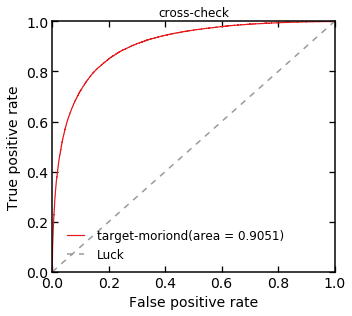

In [37]:
plot_rocs(rocs_valid, label='cross-check', title = 'cross-check')

In [40]:
def compare_train_test(clf,x_train,y_train,w_train,x_test,y_test,w_test, bins=100, label=''):
    fig = plt.figure(figsize=(5,5))
    plt.title(label)
    decisions = []
    weight    = []
    print clf
    for x,y,w in ((x_train, y_train, w_train), (x_test, y_test, w_test)):
        print x.shape
        #d1 = clf.predict_proba(x[y>0.5])[:,1]
        #d2 = clf.predict_proba(x[y<0.5])[:,1].ravel()
        d1 = evaluate_sklearn(clf,x[y>0.5])
        d2 = evaluate_sklearn(clf,x[y<0.5])
        w1 = w[y>0.5]
        w2 = w[y<0.5]
        decisions += [d1, d2]
        weight    += [w1, w2]
        
    low  = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             weights = weight[0], 
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             weights = weight[1], 
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True, weights = weight[2] )
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='.', c='r', label='S (test)', markersize=8,capthick=0)
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True, weights = weight[3])
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='.', c='b', label='B (test)', markersize=8,capthick=0)

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    plt.ylim([0.01, 2*max(hist)])
    plt.savefig('overtrain_%s.pdf' % label)
    plt.show()

 ---  target-moriond
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.001, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=1,
              warm_start=False)
(172417, 10)
(689669, 10)


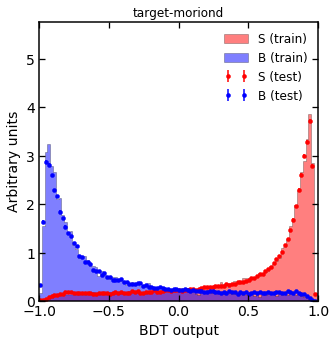

In [41]:
for i, c in clfs.items():
    print " --- ", i
    compare_train_test(c,
                       X_train,Y_train,W_train, 
                       X_valid,Y_valid,W_valid, label=i)